In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)
        
print('GPU ready')

GPU ready


In [17]:
# 사진별로 번호 멕이기

#csv
import pandas as pd

category_csv = pd.read_csv('./data/category.csv')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)

{'be': 0, 'bottle': 1, 'glass': 2, 'jj': 3, 'me': 4, 'soju': 5, 'vita': 6, 'wine': 7, 'ww': 8}


In [18]:
#이미지 불러오기
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = './data/data/'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
    )
    # 이미지 불러옴
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(299, 299),
        classes=label_dict,
        subset='training',
        batch_size = 50,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(299, 299),
        classes=label_dict,
        subset='validation',
        batch_size = 10,
        class_mode="sparse"
    )

Found 100 images belonging to 9 classes.
Found 20 images belonging to 9 classes.


In [19]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential

with tf.device('/device:GPU:0'):

    Xception_model_base = Xception(weights='imagenet',
                       include_top=False,
                       input_shape=(299,299,3))
    Xception_model_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [20]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.applications import DenseNet201
# from tensorflow.keras.layers import GlobalAveragePooling2D
# from tensorflow_addons.optimizers import RectifiedAdam
# from tensorflow.keras.optimizers import Adam,SGD


with tf.device('/device:GPU:0'):

    Xception_model_base = Xception(weights='imagenet',
                       include_top=False,
                       input_shape=(299,299,3))

    Xception_model_base.trainable = False  # Convolution Layer 동결

    model = Sequential()
    model.add(Xception_model_base)
    
    model.add(Flatten(input_shape=(10*10*2048,)))
    model.add(Dense(9,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    # adjust learning rate
#     def get_lr_callback():
#         lr_start   = 0.000001*10*0.5
#         lr_max     = 0.0000005 * 12 * 10*0.5
#         lr_min     = 0.000001 * 10*0.5
#         lr_ramp_ep = 5
#         lr_sus_ep  = 0
#         lr_decay   = 0.8


#         def lrfn(epoch):
#             if epoch < lr_ramp_ep:
#                 lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
#             elif epoch < lr_ramp_ep + lr_sus_ep:
#                 lr = lr_max    
#             else:
#                 lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
#             return lr

#         lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
#         return lr_callback
    
    
    # Model saving callback
    checkpointer = ModelCheckpoint(filepath='./model/recycle_Xception_1205.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

    epochs = 500
    history = model.fit_generator(
        trainGen, 
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        steps_per_epoch=2, 
        validation_data=validationGen,
        validation_steps=2,
        verbose=1
    )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1843209   
Total params: 22,704,689
Trainable params: 1,843,209
Non-trainable params: 20,861,480
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2 steps, validate for 2 steps
Epoch 1/500
1/2 [==============>...............] - ETA: 3s - loss: 2.2971 - sparse_categorical_accuracy: 0.1400
Epoch 00001: val_loss improved from inf to 3.47477, saving model to ./model/recycle_Xception_1205.h5
2/2 [==============================] - 5s 3s/step - loss: 3.3

Epoch 21/500
1/2 [==============>...............] - ETA: 1s - loss: 0.1495 - sparse_categorical_accuracy: 0.9600
Epoch 00021: val_loss did not improve from 0.33817
2/2 [==============================] - 3s 1s/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9400 - val_loss: 0.5395 - val_sparse_categorical_accuracy: 0.8500
Epoch 22/500
1/2 [==============>...............] - ETA: 1s - loss: 0.0533 - sparse_categorical_accuracy: 1.0000
Epoch 00022: val_loss did not improve from 0.33817
2/2 [==============================] - 3s 1s/step - loss: 0.0752 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.5027 - val_sparse_categorical_accuracy: 0.8500
Epoch 23/500
1/2 [==============>...............] - ETA: 1s - loss: 0.0917 - sparse_categorical_accuracy: 0.9800
Epoch 00023: val_loss did not improve from 0.33817
2/2 [==============================] - 3s 1s/step - loss: 0.0600 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.3943 - val_sparse_categorical_accuracy: 0.8500
Epoch 24/500
1/2

Epoch 45/500
1/2 [==============>...............] - ETA: 1s - loss: 0.1825 - sparse_categorical_accuracy: 0.9400
Epoch 00045: val_loss did not improve from 0.14429
2/2 [==============================] - 3s 1s/step - loss: 0.1484 - sparse_categorical_accuracy: 0.9600 - val_loss: 0.1760 - val_sparse_categorical_accuracy: 0.9500
Epoch 46/500
1/2 [==============>...............] - ETA: 1s - loss: 0.0245 - sparse_categorical_accuracy: 1.0000
Epoch 00046: val_loss did not improve from 0.14429
2/2 [==============================] - 3s 1s/step - loss: 0.0155 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1574 - val_sparse_categorical_accuracy: 0.9500
Epoch 47/500
1/2 [==============>...............] - ETA: 1s - loss: 0.0077 - sparse_categorical_accuracy: 1.0000
Epoch 00047: val_loss did not improve from 0.14429
2/2 [==============================] - 3s 1s/step - loss: 0.0097 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1915 - val_sparse_categorical_accuracy: 0.9500
Epoch 48/500
1/2

Epoch 70/500
1/2 [==============>...............] - ETA: 1s - loss: 0.0012 - sparse_categorical_accuracy: 1.0000
Epoch 00070: val_loss did not improve from 0.09764
2/2 [==============================] - 3s 1s/step - loss: 0.0023 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1516 - val_sparse_categorical_accuracy: 0.9500
Epoch 71/500
1/2 [==============>...............] - ETA: 1s - loss: 4.5212e-04 - sparse_categorical_accuracy: 1.0000
Epoch 00071: val_loss did not improve from 0.09764
2/2 [==============================] - 3s 1s/step - loss: 0.0125 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2113 - val_sparse_categorical_accuracy: 0.9000
Epoch 72/500
1/2 [==============>...............] - ETA: 1s - loss: 0.2663 - sparse_categorical_accuracy: 0.9200
Epoch 00072: val_loss did not improve from 0.09764
2/2 [==============================] - 3s 1s/step - loss: 0.1612 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.1397 - val_sparse_categorical_accuracy: 0.9500
Epoch 73/500

Epoch 94/500
1/2 [==============>...............] - ETA: 1s - loss: 0.0335 - sparse_categorical_accuracy: 0.9800
Epoch 00094: val_loss did not improve from 0.05021
2/2 [==============================] - 3s 1s/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.3389 - val_sparse_categorical_accuracy: 0.9000
Epoch 95/500
1/2 [==============>...............] - ETA: 1s - loss: 0.0158 - sparse_categorical_accuracy: 1.0000
Epoch 00095: val_loss did not improve from 0.05021
2/2 [==============================] - 3s 1s/step - loss: 0.0087 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1706 - val_sparse_categorical_accuracy: 0.9000
Epoch 96/500
1/2 [==============>...............] - ETA: 1s - loss: 0.0116 - sparse_categorical_accuracy: 1.0000
Epoch 00096: val_loss did not improve from 0.05021
2/2 [==============================] - 3s 1s/step - loss: 0.0390 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.3672 - val_sparse_categorical_accuracy: 0.8500
Epoch 97/500
1/2

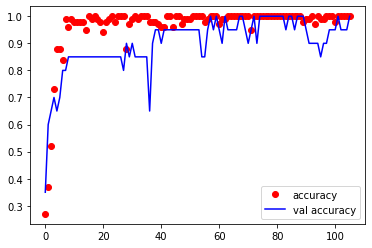

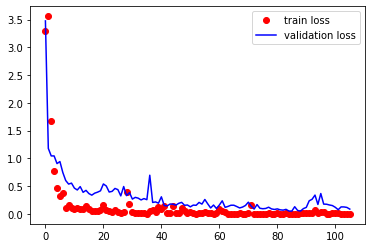

In [21]:
# 모델 확인
import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.plot(train_acc,'bo', color='r', label='accuracy')
plt.plot(val_acc,'b', color='b', label='val accuracy')
plt.legend()
plt.show()


train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'bo', color='r', label='train loss')
plt.plot(val_loss,'b', color='b', label='validation loss')
plt.legend()
plt.show()

[5. 2. 6. 3. 1. 6. 7. 8. 6. 7.]
[7.6703861e-02 1.0054076e-02 9.1203648e-01 1.9137421e-07 6.3600244e-05
 2.4100837e-06 8.1320939e-04 5.2696369e-06 3.2088376e-04]
Confusion Matrix
[5 2 6 3 1 6 7 8 6 7]


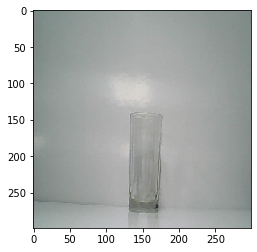

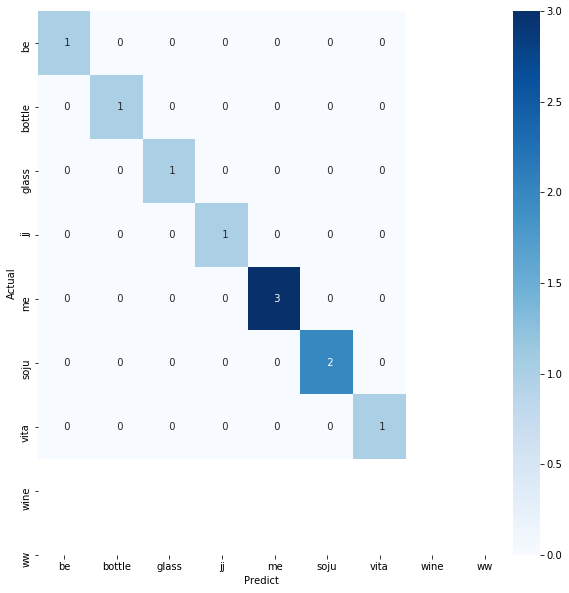

In [24]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):


    model_path = './model/recycle_Xception_1205.h5'


    Xception_model = tf.keras.models.load_model(model_path)

# Train 데이터
    x_train, y_train= validationGen.next()
    print(y_train)
    plt.imshow(x_train[1])

# 예측값
    #Confution Matrix and Classification Report
    Y_pred = Xception_model.predict_generator(validationGen, 1)
    
    print(Y_pred[1])

    y_pred = np.argmax(Y_pred, axis=1)


    print('Confusion Matrix')
    # display(confusion_matrix(validationGen.classes, y_pred))

    print(y_pred)





    fig, ax = plt.subplots(figsize=(10,10))  # inch단위로 그림의 크기
    sns.heatmap(
        confusion_matrix(y_train, y_pred),
        annot = True, # 숫자표현
        fmt = '3d',    # 정수표현     
        cmap = 'Blues', # color 색상
        ax = ax,       # 그래프로 사용할 subplot
        xticklabels=category_csv['bottle_name'], 
        yticklabels=category_csv['bottle_name']
    )
    ax.set_xlabel('Predict')
    ax.set_ylabel('Actual')
    plt.show()